# 01 Introductionary Experiments to Disjoint Generative Models

In this first series of experiments for the paper, we explore the efficacy of disjoint generative models (DGMs), under the simplest conditions. The goal is to show that DGMs work as expected and can be used to increase privacy of synthetic data with the simple act of introducing partitions.

In paricular, we will experiment with using the same generative model for each partition, so as to keep as few experimental parameters moving at the same time. Intuitively, compared to just using the generative model on the full column-set, introducing partitions should harm utility and increase privacy, since the cross-correlations between variables in separate partitions are reduced. At the same time, efficiency of certain models e.g. Bayesian Networks should increase, since the number of variables in the model is reduced.

### Experimental Setup

For the individual dataset experiments below we will use the Breast Cancer dataset from [Kaggle](https://www.kaggle.com/datasets/reihanenamdari/breast-cancer/). We will throughout this notebook use the following models: [Synthpop](https://www.synthpop.org.uk/get-started.html) sequential CART, [DataSynthesizer](https://github.com/DataResponsibly/DataSynthesizer) Bayesian Network, and [CTGAN](https://github.com/sdv-dev/CTGAN). We will use a wide selection of metrics from [SynthEval](https://github.com/schneiderkamplab/syntheval) to carry out the evaluation.

In [1]:
### Imports
import pandas as pd

from pandas import DataFrame
from typing import List, Dict

from disjoint_generative_model import DisjointGenerativeModels
from disjoint_generative_model.utils.joining_strategies import UsingJoiningValidator, Concatenating

from disjoint_generative_model.utils.generative_model_adapters import generate_synthetic_data

from experiments.auxiliaries.results_presentation import create_comparison_table
from experiments.auxiliaries.exp_repeater import repeated_experiment, repeated_experiment_timed

### Constants
NUM_REPS = 10

### Metrics
metrics = {
    "pca"       : {},
    "h_dist"    : {},
    "corr_diff" : {"mixed_corr": True},
    "auroc_diff": {"model": "rf_cls"},
    "cls_acc"   : {"F1_type": "macro"},
    "eps_risk"  : {},
    "dcr"       : {},
    "mia"       : {"num_eval_iter": 5},
}

In [2]:
### Load data
df_train = pd.read_csv('experiments/datasets/breast_cancer_train.csv')
df_test = pd.read_csv('experiments/datasets/breast_cancer_test.csv')

label = 'Status'

In [ ]:
### Create Baselines for each model (do also 10 repeats)
baselines = ['synthpop','ctgan']

for model in baselines:

    def generate_baseline(df_train: DataFrame, id: int = None) -> DataFrame:
        df_syn = generate_synthetic_data(df_train, model, id=id)
        return df_syn

    res = repeated_experiment(df_train, df_test, label, generate_baseline, NUM_REPS, metrics)
    res.to_csv(f'experiments/results/breast_cancer_case_study/{model}_baseline.csv')

In [4]:
df_synthpop = pd.read_csv('experiments/results/breast_cancer_case_study/synthpop_baseline.csv')
df_ctgan = pd.read_csv('experiments/results/breast_cancer_case_study/ctgan_baseline.csv')

df_synthpop

,Unnamed: 0,mean,sem
0,pca_eigval_diff,0.011079,0.001219
1,pca_eigvec_ang,0.112272,0.026777
2,avg_h_dist,0.005753,0.000271
3,corr_mat_diff,0.154334,0.005938
4,auroc,0.016140,0.002259
5,cls_F1_diff,0.008290,0.000519
6,cls_F1_diff_hout,0.011933,0.001640
7,eps_identif_risk,0.592669,0.001978
8,priv_loss_eps,0.401180,0.001857
9,median_DCR,0.898347,0.006074


## Using Random Concatenation of Partitions

In this first experiment the joining is done by randomly concatenating the partitions. Under this scheme, the cross-correlations between variables in different partitions are minimal, and the effects on utility and privacy should be most pronounced.

In [ ]:
model = 'synthpop'
NUM_PARTS = 2

def same_model_split(df_train: DataFrame, id: int = None) -> DataFrame:
    JS = Concatenating()
    dgms = DisjointGenerativeModels(df_train, NUM_PARTS*[model], joining_strategy=JS, worker_id=id*100)
    df_syn = dgms.fit_generate()
    return df_syn

res = repeated_experiment(df_train, df_test, label, same_model_split, NUM_REPS, metrics)
res.to_csv(f'experiments/results/breast_cancer_case_study/{model}_{NUM_PARTS}_partitions_concat.csv')

In [6]:
create_comparison_table('experiments/results/breast_cancer_case_study/synthpop_baseline.csv', 
                        'experiments/results/breast_cancer_case_study/synthpop_2_partitions_concat.csv', 
                        'synthpop baseline', '2 partitions')

,synthpop baseline,2 partitions,diff %,z_score,p_value
pca_eigval_diff,0.011079,0.030212,-63.328681,-6.072999,1.255430e-09
pca_eigvec_ang,0.112272,0.099635,12.682752,0.356971,7.211132e-01
avg_h_dist,0.005753,0.005338,7.784449,1.042039,2.973936e-01
corr_mat_diff,0.154334,1.640158,-90.590273,-8.427678,0.000000e+00
auroc,0.016140,0.116027,-86.089157,-3.765356,1.663117e-04
cls_F1_diff,0.008290,0.116286,-92.871186,-3.175072,1.497993e-03
cls_F1_diff_hout,0.011933,0.124061,-90.381211,-3.229618,1.239556e-03
eps_identif_risk,0.592669,0.321280,84.471089,9.876171,0.000000e+00
priv_loss_eps,0.401180,0.170208,135.699945,11.348488,0.000000e+00
median_DCR,0.898347,3.701072,-75.727378,-5.234621,1.653234e-07


In the table, the results from the baseline and 2-partitions model is shown. We also calculate percentage difference, z-values and p-values to aid in the intrepretation. Evidently, the results are significantly worse from the baseline on most utility metrics, and significantly better on most privacy measures (DCR is better when high). Also Note that H-dist is basically unchanged, which is expected since the metric only measures the marginal distributions of the data, and this has not changed when using random concatenation of partitions. 

### Redo experiment separatly for the datasynthesizer model

We generate the results for the datasynthesizer model separatly (and not in parallel), since we also want to measure if we gain a measureable difference in performance.

In [ ]:
NUM_PARTS = 2
model = 'datasynthesizer'

res = repeated_experiment_timed(df_train, df_test, label, generate_baseline, NUM_REPS, metrics)
res.to_csv(f'experiments/results/breast_cancer_case_study/{model}_baseline.csv')

res = repeated_experiment_timed(df_train, df_test, label, same_model_split, NUM_REPS, metrics)
res.to_csv(f'experiments/results/breast_cancer_case_study/{model}_{NUM_PARTS}_partitions_concat.csv')

In [8]:
create_comparison_table('experiments/results/breast_cancer_case_study/datasynthesizer_baseline.csv',
                        'experiments/results/breast_cancer_case_study/datasynthesizer_2_partitions_concat.csv',
                        'datasynthesizer baseline', '2 partitions')

,datasynthesizer baseline,2 partitions,diff %,z_score,p_value
pca_eigval_diff,0.027310,0.035705,-23.513348,-2.534830,0.011250
pca_eigvec_ang,0.148805,0.179807,-17.242107,-0.608886,0.542600
avg_h_dist,0.006165,0.005754,7.140304,0.829492,0.406826
corr_mat_diff,0.485974,2.328769,-79.131699,-23.083359,0.000000
auroc,0.041154,0.105036,-60.819647,-2.169724,0.030028
cls_F1_diff,0.016082,0.109843,-85.358830,-2.604930,0.009189
cls_F1_diff_hout,0.025846,0.112708,-77.068065,-2.555372,0.010607
eps_identif_risk,0.445045,0.188816,135.702534,19.770920,0.000000
priv_loss_eps,0.264741,0.077011,243.767648,21.077597,0.000000
median_DCR,1.076864,4.960124,-78.289583,-9.156515,0.000000


It appers that there is a significant decrease in time to perform the full fit and synthesis with the Datasynthesizer BN model when going from N variables to 2*(N/2) variables.

## Using Joining Validator for Assembley

Now that we have seen that the random concatenation of partitions yield the expected results, it is time to explore how a more deliberate joining procedure can decrease the loss in utility while keeping privacy gains. We will use the Joining Validator equipped with a Random Forest model to perform the validation (validator models are explained in the paper and in [Case Study 3](04_joining_validator.ipynb)), furthermore, we will introduce an additional partition to show that the model can handle more than two partitions.

In [ ]:
model = 'synthpop'
NUM_PARTS = 3

def same_model_split(df_train: DataFrame, id: int = None) -> DataFrame:
    JS = UsingJoiningValidator(behaviour='adaptive')
    dgms = DisjointGenerativeModels(df_train, NUM_PARTS*[model], joining_strategy=JS, worker_id=id*100)
    df_syn = dgms.fit_generate()
    return df_syn

res = repeated_experiment(df_train, df_test, label, same_model_split, NUM_REPS, metrics)
res.to_csv(f'experiments/results/breast_cancer_case_study/{model}_{NUM_PARTS}_partitions_valid.csv')

In [22]:
create_comparison_table('experiments/results/breast_cancer_case_study/synthpop_baseline.csv',
                        'experiments/results/breast_cancer_case_study/synthpop_3_partitions_valid.csv',
                        'synthpop baseline', '3 partitions')

,synthpop baseline,3 partitions,diff %,z_score,p_value
pca_eigval_diff,0.011079,0.046493,-76.170580,-5.302078,1.144916e-07
pca_eigvec_ang,0.112272,0.077213,45.404791,1.152343,2.491801e-01
avg_h_dist,0.005753,0.030833,-81.340950,-9.691439,0.000000e+00
corr_mat_diff,0.154334,1.005636,-84.653053,-7.558479,4.085621e-14
auroc,0.016140,0.049494,-67.389673,-3.022683,2.505449e-03
cls_F1_diff,0.008290,0.068967,-87.979924,-3.066787,2.163730e-03
cls_F1_diff_hout,0.011933,0.079258,-84.943907,-3.346315,8.189322e-04
eps_identif_risk,0.592669,0.466480,27.051145,7.161399,7.984724e-13
priv_loss_eps,0.401180,0.289717,38.473086,7.748803,9.325873e-15
median_DCR,0.898347,1.212588,-25.914885,-1.326207,1.847711e-01


It appers, that the performance on utility is better than in the random concatenation scheme but that the gain in privacy is less. Hellinger distance is now more affected since the joining influences which items are included. As is explored later in [Case Study 3](04_joining_validator.ipynb), the Joining Validator can be tuned to control the trade-off between utility and privacy to a higher degree than with what is shown here.

## Experiments With More Datasets and More Partitions

With the preliminary results above illustrating the premise of the idea; that privacy can be significantly improved by introducing partitions in the workflow of synthetic data generation, and that utility can be controlled using the joining scheme, it is now time to show that the results generalise on other datasets, and that they scale with additional partitions.

We will thoroughly extend the results to seven datasets (shown in the table) across the three models mentioned above. 

| key | Dataset | # records | # attributes |
| --- | ------- | --------- | ------------ |
| al | [alzheimer's disease](https://www.kaggle.com/datasets/rabieelkharoua/alzheimers-disease-dataset) | 1719+430 | 33 |
| bc | [breast cancer](https://www.kaggle.com/datasets/reihanenamdari/breast-cancer) | 3219+805 | 16 |
| cc | [cervical cancer](https://archive.ics.uci.edu/dataset/383/cervical+cancer+risk+factors) | 534+134 | 34 |
| hd | [heart disease](https://archive.ics.uci.edu/dataset/45/heart+disease) | 242+61 | 14 |
| hp | [hepatitis](https://archive.ics.uci.edu/dataset/503/hepatitis+c+virus+hcv+for+egyptian+patients) | 1105+276 | 29 |
| kd | [kidney disease](https://archive.ics.uci.edu/dataset/336/chronic+kidney+disease) | 126+32 | 25 |
| st | [stroke](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset) | 3927+982 | 11 |

The experiment is performed in [01_same_model_parts_results.py](experiments/auxiliaries/01_same_model_parts_results.py) and the results file is [parallel_time_utility_privacy.csv](experiments/results/parallel_time_utility_privacy.csv). We present them in plots below.

In [1]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
rcp = {'font.size': 9, 'font.family': 'sans', "mathtext.fontset": "dejavuserif"}
plt.rcParams.update(**rcp)

def time_privacy_and_utility_figure(results, models, metrics, return_flag=True):

    fig, axes = plt.subplots(len(metrics), len(models), figsize=(7, 8), sharex=True, sharey='row')

    for j, model in enumerate(models):
        for i, metric in enumerate(metrics):
            axes[i, j].minorticks_on()
            axes[i, j].xaxis.set_tick_params(which='minor', bottom=False)
            axes[i, j].yaxis.grid(True, which='major', linestyle='--', linewidth='0.5', alpha=0.3)
            sns.pointplot(data=results[results['model']==model], x="partitions", y=metric, hue="data", ax=axes[i, j], palette='rocket', capsize=.1, linewidth=1.5, errorbar='se')
            axes[i, j].get_legend().remove()

            if i == 0:axes[i, j].set_title(model)

            # if i == len(metric)-1:
            #     axes[i, j].set_xlabel('# of subsets')

    axes[i, 0].legend(fontsize=7, loc='lower left', ncol=2)
    plt.tight_layout()

    if return_flag == True:
        return fig
    else:
        plt.savefig(f"experiments/results/figures/figure2_metrics_vs_partitions.pdf", bbox_inches='tight')
        pass

/home/lautrup/sdg_env/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/lautrup/sdg_env/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/lautrup/sdg_env/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/lautrup/sdg_env/lib/python3.10/site-package

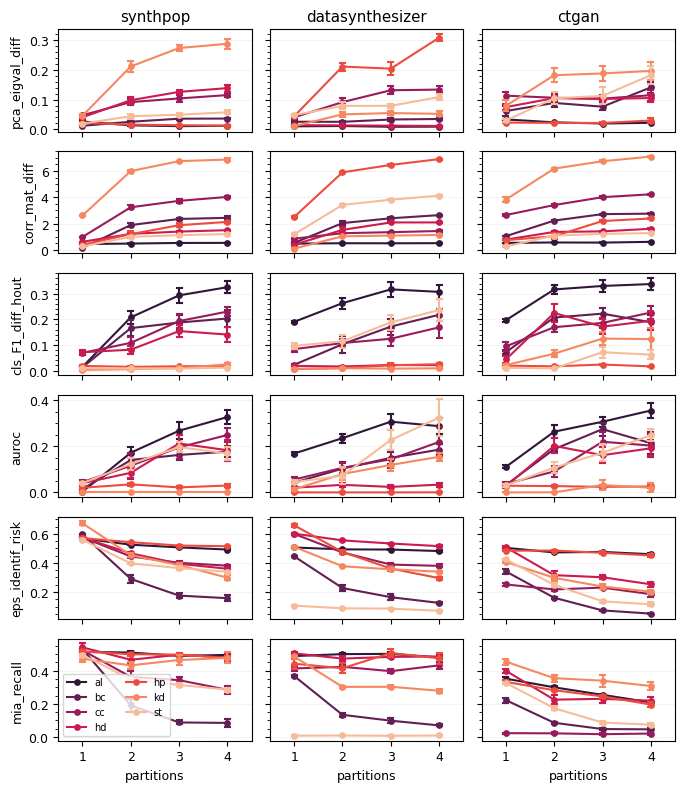

In [3]:
models = ['synthpop', 'datasynthesizer', 'ctgan']
metrics = ['pca_eigval_diff', 'corr_mat_diff', 'cls_F1_diff_hout', 'auroc', 'eps_identif_risk', 'mia_recall']

results = pd.read_csv('experiments/results/01_utility_privacy_concat.csv')

fig = time_privacy_and_utility_figure(results, models, metrics, return_flag=False)

### Higher-Dimensional Dataset

Now that we have seen the behaviour generally follows the expected pattern, we will also show an example of a higher-dimensional dataset, with a higher number of partitions. 
We will limit ourselves to the DataSynthesizer model for this experiment, since it is the model that is impacted the most by the number of variables in the model. We will use the [diabetic mellitus](https://www.openml.org/search?type=data\&status=active\&id=41430) from OpenML which has 281 records and 98 features.

In [8]:
import pandas as pd

df_train = pd.read_csv('experiments/datasets/diabetic_mellitus_train.csv')
df_test = pd.read_csv('experiments/datasets/diabetic_mellitus_test.csv')